In [130]:
import sys
import os

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

sys.path.append(os.getenv('SPARSE_PROBING_ROOT'))
from activations.activation_subset import load_activation_subset
from load import load_feature_dataset

## Build Datastructures and Functions For Viewing Results

In [131]:
# store all of the activations in a dictionary
datasets = [
    {
        'property': 'sex_or_gender',
        'size': 6000,
        'classes': ['female', 'male'],
    },
    {
        'property': 'political_party',
        'size': 3000,
        'classes': ['Democratic Party', 'Republican Party'],
    },
    {
        'property': 'occupation',
        'size': 6000,
        'classes': ['actor', 'journalist', 'politician',
                    'researcher', 'singer', 'athlete'],
    },
    {
        'property': 'is_alive',
        'size': 6000,
        'classes': ['true', 'false'],
    },
    {
        'property': 'occupation_athlete',
        'size': 5000,
        'classes': ['association football player', 'basketball player', 'American football player',
                    'baseball player', 'ice hockey player'],
    },
]

model_size = '6.9b'
prefix = 'wikidata_sorted'

In [132]:
# load feature dataset so we can see class labels
def get_neuron_activations(neurons, activation_subset, fd, classes, use_max_aggregation=True):
    neuron_activations = {}
    for neuron in neurons:
        class_activations = {}
        for c in classes:
            class_indices = np.array([x == c for x in fd['class']])
            if use_max_aggregation:
                surname_index_start = np.array(fd['surname_index_start'])[class_indices]
                surname_index_end = np.array(fd['surname_index_end'])[class_indices]
                n_activations = activation_subset[neuron][class_indices]

                activation_list = []
                for i, (six, eix) in enumerate(zip(surname_index_start, surname_index_end)):
                    activation_list.append(n_activations[i][six:eix+1].max().item())
                class_activations[c] = np.array(activation_list)
            else:
                surname_index_end = np.array(fd['surname_index_end'])[class_indices]
                class_activations[c] = activation_subset[neuron][class_indices, surname_index_end]

        neuron_activations[neuron] = class_activations
    return neuron_activations

In [133]:
model = f'pythia-{model_size}'

results = {}
for dataset_info in datasets:
    dataset_str = f'{prefix}_{dataset_info["property"]}.pyth.128.{dataset_info["size"]}'
    activations_path = os.path.join(os.getenv('RESULTS_DIR'), 'activation_subset', model, dataset_str)
    if not os.path.exists(activations_path):
        continue

    list_dir = os.listdir(activations_path)
    if 'top_fact_neurons' in list_dir:
        list_dir.remove('top_fact_neurons')
    experiment_name = sorted(list_dir)[-1]  # tiebreak with larger filename (later experiment)
    # print(dataset_info, experiment_name, sorted(os.listdir(activations_path)))

    out = load_activation_subset(model, dataset_str, experiment_name, os.getenv('RESULTS_DIR'))
    if len(out) == 2:
        activation_subset, metadata = out
        token_summary_df = None
    elif len(out) == 3:
        activation_subset, metadata, token_summary_df = out
    classes = dataset_info['classes']
    all_neurons = list(activation_subset.keys())

    # load interpretable neurons
    neuron_df_path = os.path.join(os.getenv('SPARSE_PROBING_ROOT'), 'interpretable_neurons', model, 'wikidata.csv')
    neuron_df = pd.read_csv(neuron_df_path)
    neuron_df = neuron_df.query(f'dataset=="{dataset_str}"')
    class_neurons = {}
    class_neuron_stats = {}
    for c in classes:
        class_neurons[c] = neuron_df.query(f'feature=="{c}"')[['layer', 'neuron']].values.tolist()
        class_neurons[c] = [tuple(n) for n in class_neurons[c]]

        stats_cols = ['test_mcc', 'test_f1_score', 'coef']
        stats_array = neuron_df.query(f'feature=="{c}"')[stats_cols].values
        class_neuron_stats[c] = [dict(zip(stats_cols, stats_array[i])) for i in range(stats_array.shape[0])]

    # load feature dataset so we can get class labels
    fd = load_feature_dataset(dataset_str)
    neuron_activations = get_neuron_activations(all_neurons, activation_subset, fd, classes)

    results[dataset_info['property']] = {
        'classes': classes,
        'activation_subset': activation_subset,
        'metadata': metadata,
        'token_summary_df': token_summary_df,
        'all_neurons': all_neurons,
        'neuron_activations': neuron_activations,
        'class_neurons': class_neurons,
        'class_neuron_stats': class_neuron_stats,
        'feature_dataset': fd,
    }

In [134]:
activation_subset_all = {}
for r in results.values():
    for k, v in r['activation_subset'].items():
        activation_subset_all[k] = v
len(activation_subset_all)

138

In [135]:
# print top and bottom tokens for each neuron
def get_top_tokens(property, n=5):
    classes = results[property]['classes']
    class_neurons = results[property]['class_neurons']
    class_neuron_stats = results[property]['class_neuron_stats']
    for c in classes:
        print(f'Class: {c}')
        for (lix, nix), stats in zip(class_neurons[c], class_neuron_stats[c]):
            token_summary_df = results[property]['token_summary_df']
            tokens = token_summary_df.query(f'layer=={lix} and neuron=={nix}').sort_values(
                'mean', ascending=True).string.values

            print(f'\t({lix}, {nix}) mcc={stats["test_mcc"]:.2f} f1={stats["test_f1_score"]:.2f} coef={stats["coef"]:.2f}')
            print(f'\t\tHigh activation tokens: {tokens[-n:]}')
            print(f'\t\tLow activation tokens: {tokens[:n]}')

In [136]:
# get max and min activating names of the target class for each neuron
def get_top_names(property, n=5):
    classes = results[property]['classes']
    neuron_activations = results[property]['neuron_activations']
    class_neurons = results[property]['class_neurons']
    class_neuron_stats = results[property]['class_neuron_stats']
    fd = results[property]['feature_dataset']

    for c in classes:
        print(f'Class {c}')
        class_indices_bool = np.array([x == c for x in fd['class']])
        class_indices = np.where(class_indices_bool)[0]
        for neuron, stats in zip(class_neurons[c], class_neuron_stats[c]):
            print(f'\t{neuron} mcc={stats["test_mcc"]:.2f} f1={stats["test_f1_score"]:.2f} coef={stats["coef"]:.2f}')
            print(f'\t\tFor class {c}')
            max_indices = neuron_activations[neuron][c].argsort()[-n:][::-1]
            min_indices = neuron_activations[neuron][c].argsort()[:n]
            print(f"\t\t\tMax activating names: {np.array(fd['name'])[class_indices[max_indices]]}")
            print(f"\t\t\tMin activating names: {np.array(fd['name'])[class_indices[min_indices]]}")

In [137]:
all_colors = ['lightblue', 'lightgreen', 'lightpink', 'lightyellow',
              'lightgray', 'lightcyan', 'lightcoral', 'lightseagreen',
              'lightsalmon', 'lightsteelblue']

In [138]:
def boxplot_all(property, title=None, figsize=(10, 5), whis=(5, 95),
                colors=all_colors, rotation=30):
    neurons = results[property]['all_neurons']
    classes = results[property]['classes']
    neuron_activations = results[property]['neuron_activations']

    fig, ax = plt.subplots(figsize=figsize)

    box_width = 0.7
    positions = []
    for i in range(len(neurons)):
        positions.append([i * (len(classes) + 1) + (j * box_width) + 1 for j in range(len(classes))])
    flat_positions = [pos for sublist in positions for pos in sublist]

    flierprops = dict(marker='o', markersize=4, linestyle='none', alpha=0.7)
    bp = ax.boxplot([neuron_activations[n][c] for n in neurons for c in classes], patch_artist=True,
                    positions=flat_positions, widths=box_width, flierprops=flierprops, whis=whis)

    tick_positions = [(flat_positions[i] + flat_positions[i+len(classes)-1]) / 2 for i in range(0, len(flat_positions), len(classes))]
    labels = [f'{n}' for n in neurons]
    ax.set_xticks(tick_positions, labels, rotation=rotation);

    bp_colors = [colors[i] for _ in neurons for i in range(len(classes))]
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    legend_elements = [Patch(facecolor=color, label=c) for c, color in zip(classes, colors[:len(classes)])]
    ax.legend(handles=legend_elements)

    if title is None:
        title = f'Top Neurons for Property {property}'
    plt.title(title)

In [139]:
def boxplot_classes(property, title=None, figsize=None, whis=(5, 95),
                  colors=all_colors, rotation=30):
    class_neurons = results[property]['class_neurons']
    classes = results[property]['classes']
    neuron_activations = results[property]['neuron_activations']

    if figsize is None:
        figsize = (8, 5 * len(classes))
    fig, axes = plt.subplots(len(classes), 1, figsize=figsize)

    for c, ax in zip(classes, axes):
        c_neurons = class_neurons[c]

        box_width = 0.7
        positions = []
        for i in range(len(c_neurons)):
            positions.append([i * (len(classes) + 1) + (j * box_width) + 1 for j in range(len(classes))])
        flat_positions = [pos for sublist in positions for pos in sublist]

        flierprops = dict(marker='o', markersize=4, linestyle='none', alpha=0.7)
        bp = ax.boxplot([neuron_activations[n][c] for n in c_neurons for c in classes], patch_artist=True,
                        positions=flat_positions, widths=box_width, flierprops=flierprops, whis=whis)

        tick_positions = [(flat_positions[i] + flat_positions[i+len(classes)-1]) / 2 for i in range(0, len(flat_positions), len(classes))]
        labels = [f'{n}' for n in c_neurons]
        ax.set_xticks(tick_positions, labels, rotation=30);

        bp_colors = [colors[i] for _ in c_neurons for i in range(len(classes))]
        for patch, color in zip(bp['boxes'], bp_colors):
            patch.set_facecolor(color)

        legend_elements = [Patch(facecolor=color, label=c) for c, color in zip(classes, colors[:len(classes)])]
        ax.legend(handles=legend_elements)

        ax.set_title(f'class={c}')
    if title is None:
        title = f'property="{property}"'
    fig.suptitle(title, y=1.01)
    fig.tight_layout()

## Make Plots

In [140]:
get_top_tokens('political_party', n=10)

Class: Democratic Party
	(21, 1635) mcc=0.36 f1=0.72 coef=-6.99
		High activation tokens: ['regulation' 'bid' 'ocon' ' shouting' ' sliding' ' graft' ' cultivate'
 ' hardcore' 'usiness' 'atted']
		Low activation tokens: ['please' 'rb' 'pent' '\n\n\n\n\n\n\n' '167' ' 472' 'Mom' ' Premium'
 ' judged' 'Cam']
	(12, 17) mcc=0.27 f1=0.70 coef=-5.84
		High activation tokens: ['regulation' ' grabbing' ' crush' ' retaliation' ' smear' ' selectively'
 ' mold' 'usiness' ' avoids' ' coercion']
		Low activation tokens: [' conscient' 'awk' ' peaked' ' regimes' 'patient' 'phe' ' Casual' 'wrap'
 ')_' ' CALL']
	(11, 926) mcc=0.28 f1=0.69 coef=-6.52
		High activation tokens: [' Walmart' 'hler' 'patient' 'Invest' ' billions' '023' ' Respondent' '$$'
 'arson' 'usiness']
		Low activation tokens: [' Rid' ' Sed' 'iron' ' Fur' ' scream' 'ajo' ' BA' ' Kur' ' Kh' ' Sud']
	(11, 9004) mcc=0.24 f1=0.69 coef=-5.07
		High activation tokens: [' encryption' 'ensor' ' secrecy' ' deny' 'ustering' ' reluctance'
 ' forbidd

In [141]:
get_top_names('sex_or_gender')

Class female
	(12, 4043) mcc=0.96 f1=0.98 coef=26.81
		For class female
			Max activating names: ['Norma Varden' 'Teyonah Parris' 'Portia Doubleday' 'Stella Stevens'
 'Mala Powers']
			Min activating names: ['Saint Lu' 'Ray Eames' 'Ryan Newman' 'Dorian Gray' 'Melinda Gates']
	(12, 13198) mcc=0.94 f1=0.97 coef=-25.92
		For class female
			Max activating names: ['Jay Clayton' 'Brian Switek' 'Randy Crawford' 'Taylor Cole' 'Dodi Fayed']
			Min activating names: ['Rosalind Russell' 'Elizabeth George' 'Mariette Hartley' 'Debra Winger'
 'Katherine Kurtz']
	(16, 740) mcc=0.94 f1=0.97 coef=25.72
		For class female
			Max activating names: ['Loyola de Palacio' 'Najat Vallaud-Belkacem' 'Shirley Scott'
 'Catherine Parr' 'Marielle Franco']
			Min activating names: ['Casey Wilson' 'Sheridan Smith' 'Ryan Newman' 'Lee Grant' 'Sean Young']
	(19, 16039) mcc=0.90 f1=0.94 coef=24.77
		For class female
			Max activating names: ['Gila Almagor' 'Emily Browning' 'Sharmila Tagore' 'Benazir Bhutto'
 'Elizabeth 

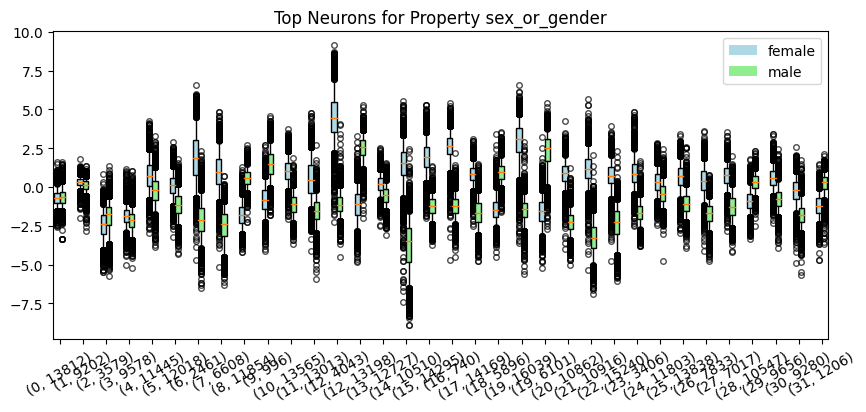

In [142]:
boxplot_all('sex_or_gender', figsize=(10, 4))

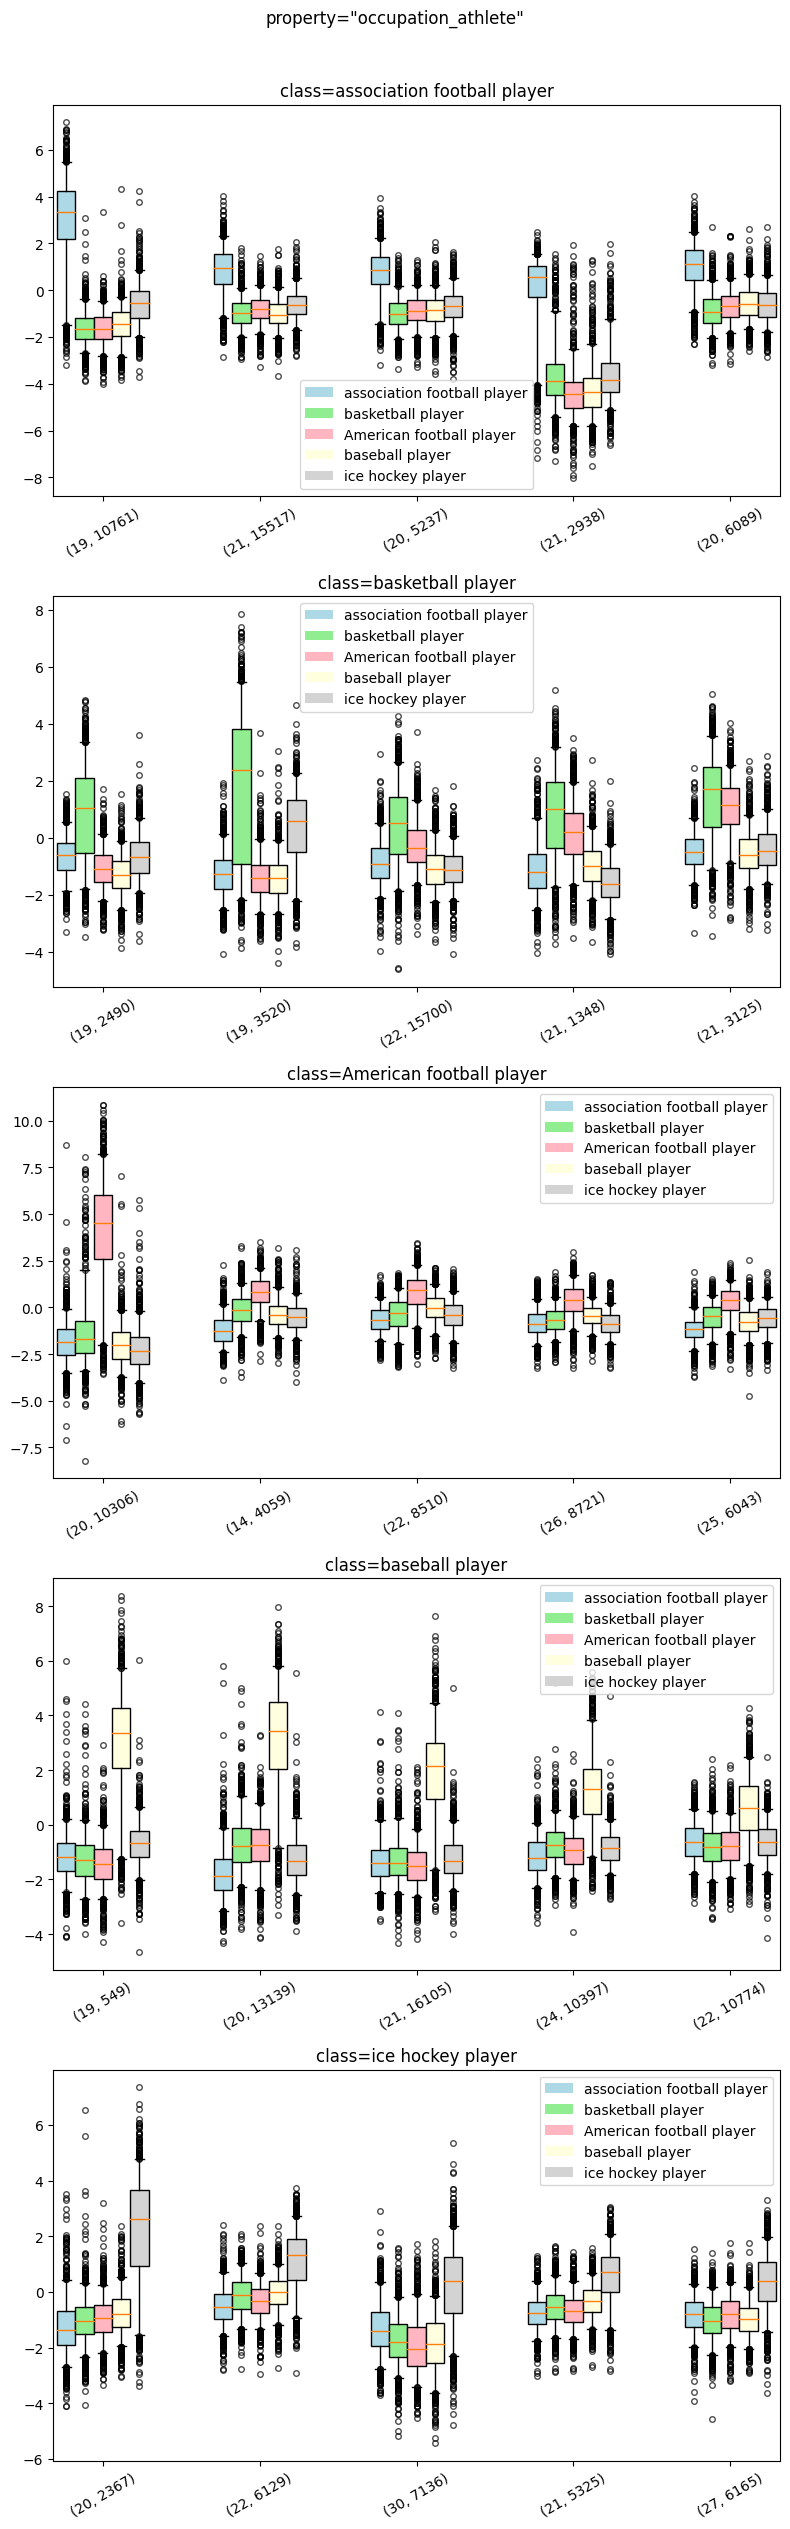

In [143]:
boxplot_classes('occupation_athlete')

### Build the main paper plot

In [144]:
activations = []
properties = []
classes = []
neurons = []
for property in results:
    for c in results[property]['classes']:
        # clean up class name
        class_name = c.lower()
        if class_name == 'american football player':
            class_name = 'football player'
        elif class_name == 'association football player':
            class_name = 'soccer player'

        for neuron in results[property]['all_neurons']:
            neuron_activations = results[property]['neuron_activations'][neuron][c].tolist()
            activations.extend(neuron_activations)
            properties.extend(len(neuron_activations) * [property])
            classes.extend(len(neuron_activations) * [class_name])
            neurons.extend(len(neuron_activations) * [neuron])

activation_df = pd.DataFrame({
    'activation': activations,
    'property': properties,
    'class': classes,
    'neuron': neurons,
})
activation_df

,activation,property,class,neuron
0,-1.251553,sex_or_gender,female,"(0, 13812)"
1,-0.541545,sex_or_gender,female,"(0, 13812)"
2,-0.376071,sex_or_gender,female,"(0, 13812)"
3,-1.045241,sex_or_gender,female,"(0, 13812)"
4,-1.213570,sex_or_gender,female,"(0, 13812)"
...,...,...,...,...
784315,1.273873,occupation_athlete,ice hockey player,"(30, 7136)"
784316,-0.340145,occupation_athlete,ice hockey player,"(30, 7136)"
784317,-1.238253,occupation_athlete,ice hockey player,"(30, 7136)"
784318,-1.478165,occupation_athlete,ice hockey player,"(30, 7136)"


In [145]:
# make the final plot
'''
plot_neurons = [
    ('sex_or_gender', (12, 4043)),  # female
    ('sex_or_gender', (12, 13198)),  # male
    ('is_alive', (17, 5653)),  # true
    ('occupation', (9, 4502)),  # actor
    ('occupation', (9, 3974)),  # journalist
    # ('occupation', (14, 11265)),  # politician (poor results)
    ('occupation', (23, 8865)),  # singer
    ('occupation', (9, 12997)),  # athlete
    ('occupation_athlete', (19, 10761)),  # soccer
    ('occupation_athlete', (20, 10306)),  # football
    ('occupation_athlete', (19, 549)),  # baseball
    ('occupation_athlete', (20, 2367)),  # hockey
]

whis = (5, 95)
fliersize = 1

fig, axes = plt.subplots(1, len(plot_neurons), figsize=(24, 6), sharey=True)

hue_order = []
for ix, (property, neuron) in enumerate(plot_neurons):
    classes = results[property]['classes']

    ax = axes[ix]
    activation_df_subset = activation_df.loc[(activation_df['neuron'] == neuron) & (activation_df['property'] == property)]
    bp = sns.boxplot(activation_df_subset, x='class', y='activation', ax=ax, whis=whis, dodge=False,
                     fliersize=fliersize, hue='class')# , hue_order=hue_order)

    ax.legend(loc='lower left', prop={'size': 8}, frameon=False)

    # formatting
    ax.set_xlabel(f'{property}\nL{neuron[0]}.N{neuron[1]}')
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_axisbelow(True)  # move grid behind the plots
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.tick_params(axis='y', which='both', length=0)
    if ix == 0:
        ax.set_ylabel('max activation over surname tokens')
    else:
        ax.set_ylabel('')
        ax.spines['left'].set_visible(False)

    ax.set_xlim([-1, len(classes)])

plt.subplots_adjust(wspace=0, hspace=0)
'''

"\nplot_neurons = [\n    ('sex_or_gender', (12, 4043)),  # female\n    ('sex_or_gender', (12, 13198)),  # male\n    ('is_alive', (17, 5653)),  # true\n    ('occupation', (9, 4502)),  # actor\n    ('occupation', (9, 3974)),  # journalist\n    # ('occupation', (14, 11265)),  # politician (poor results)\n    ('occupation', (23, 8865)),  # singer\n    ('occupation', (9, 12997)),  # athlete\n    ('occupation_athlete', (19, 10761)),  # soccer\n    ('occupation_athlete', (20, 10306)),  # football\n    ('occupation_athlete', (19, 549)),  # baseball\n    ('occupation_athlete', (20, 2367)),  # hockey\n]\n\nwhis = (5, 95)\nfliersize = 1\n\nfig, axes = plt.subplots(1, len(plot_neurons), figsize=(24, 6), sharey=True)\n\nhue_order = []\nfor ix, (property, neuron) in enumerate(plot_neurons):\n    classes = results[property]['classes']\n\n    ax = axes[ix]\n    activation_df_subset = activation_df.loc[(activation_df['neuron'] == neuron) & (activation_df['property'] == property)]\n    bp = sns.boxplot(

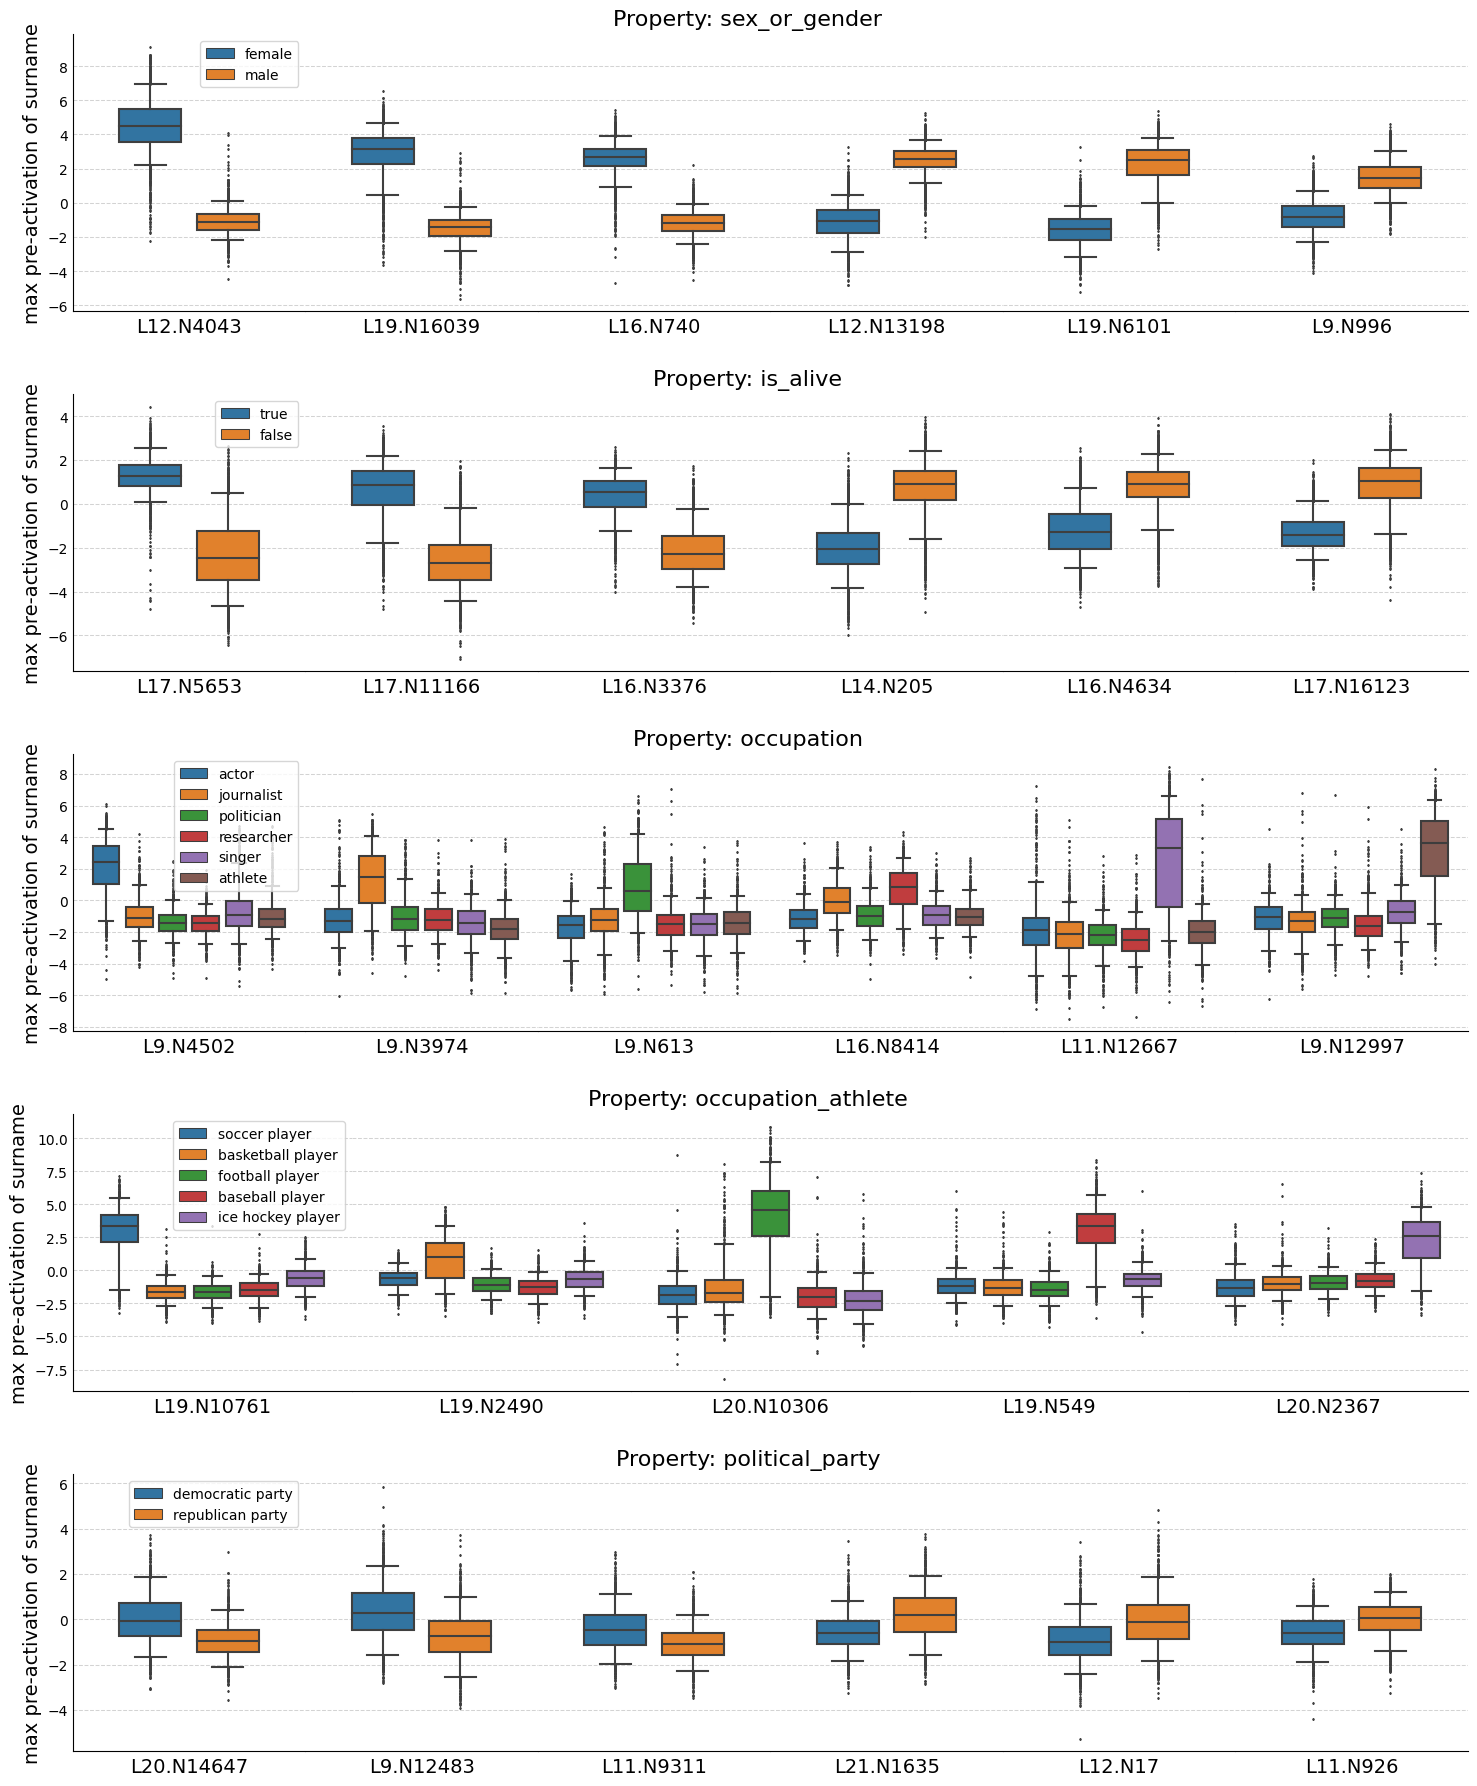

In [190]:
# make the final plot
plot_neurons_all = [
    [
        # sex_or_gender
        # female
        ('sex_or_gender', (12, 4043)),
        ('sex_or_gender', (19, 16039)),
        ('sex_or_gender', (16, 740)),
        # male
        ('sex_or_gender', (12, 13198)),
        ('sex_or_gender', (19, 6101)),
        ('sex_or_gender', (9, 996)),
    ],
    [
        # is_alive
        # true
        ('is_alive', (17, 5653)),
        ('is_alive', (17, 11166)),
        ('is_alive', (16, 3376)),
        # false
        ('is_alive', (14, 205)),
        ('is_alive', (16, 4634)),
        ('is_alive', (17, 16123)),
    ],
    [
        # occupation
        # actor
        ('occupation', (9, 4502)),
        # journalist
        ('occupation', (9, 3974)),
        # politician
        ('occupation', (9, 613)),
        # researcher
        ('occupation', (16, 8414)),
        # singer
        ('occupation', (11, 12667)),
        # athlete
        ('occupation', (9, 12997)),
    ],
    [
        # occupation_athlete
        # soccer
        ('occupation_athlete', (19, 10761)),
        # basketball
        ('occupation_athlete', (19, 2490)),
        # football
        ('occupation_athlete', (20, 10306)),
        # baseball
        ('occupation_athlete', (19, 549)),
        # hockey
        ('occupation_athlete', (20, 2367)),
        # general athlete TODO: maybe remove
        # ('occupation', (9, 12997)),
    ],
    [
        # political_party
        # democratic
        ('political_party', (20, 14647)),
        ('political_party', (9, 12483)),
        ('political_party', (11, 9311)),
        # republican
        ('political_party', (21, 1635)),
        ('political_party', (12, 17)),
        ('political_party', (11, 926)),
    ],
]

whis = (5, 95)
fliersize = 1

fig = plt.figure(figsize=(18, 18))
subfigs = fig.subfigures(len(plot_neurons_all), 1, wspace=0, hspace=.02, squeeze=False).flatten()

for subfig_ix, plot_neurons in enumerate(plot_neurons_all):
    axes = subfigs[subfig_ix].subplots(1, len(plot_neurons), sharey=True)

    hue_order = []
    for ix, (property, neuron) in enumerate(plot_neurons):
        classes = results[property]['classes']

        ax = axes[ix]
        activation_df_subset = activation_df.loc[(activation_df['neuron'] == neuron) & (activation_df['property'] == property)]
        bp = sns.boxplot(activation_df_subset, x='class', y='activation', ax=ax, whis=whis, dodge=False,
                        fliersize=fliersize, hue='class')# , hue_order=hue_order)

        # only put a legend in the first subplot
        if ix == 0:
            ax.legend(loc='upper right', prop={'size': 10}, frameon=True)
        else:
            ax.legend('', frameon=False)

        # formatting
        ax.set_xlabel(f'L{neuron[0]}.N{neuron[1]}', fontsize=14)
        ax.set_xticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_axisbelow(True)  # move grid behind the plots
        ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
        ax.tick_params(axis='y', which='both', length=0)
        if ix == 0:
            ax.set_ylabel('max pre-activation of surname', fontsize=14)
        else:
            ax.set_ylabel('')
            ax.spines['left'].set_visible(False)

        ax.set_xlim([-1, len(classes)])
    subfigs[subfig_ix].suptitle(f'Property: {property}', fontsize=16, y=.95)

fig.subplots_adjust(wspace=0, hspace=0)

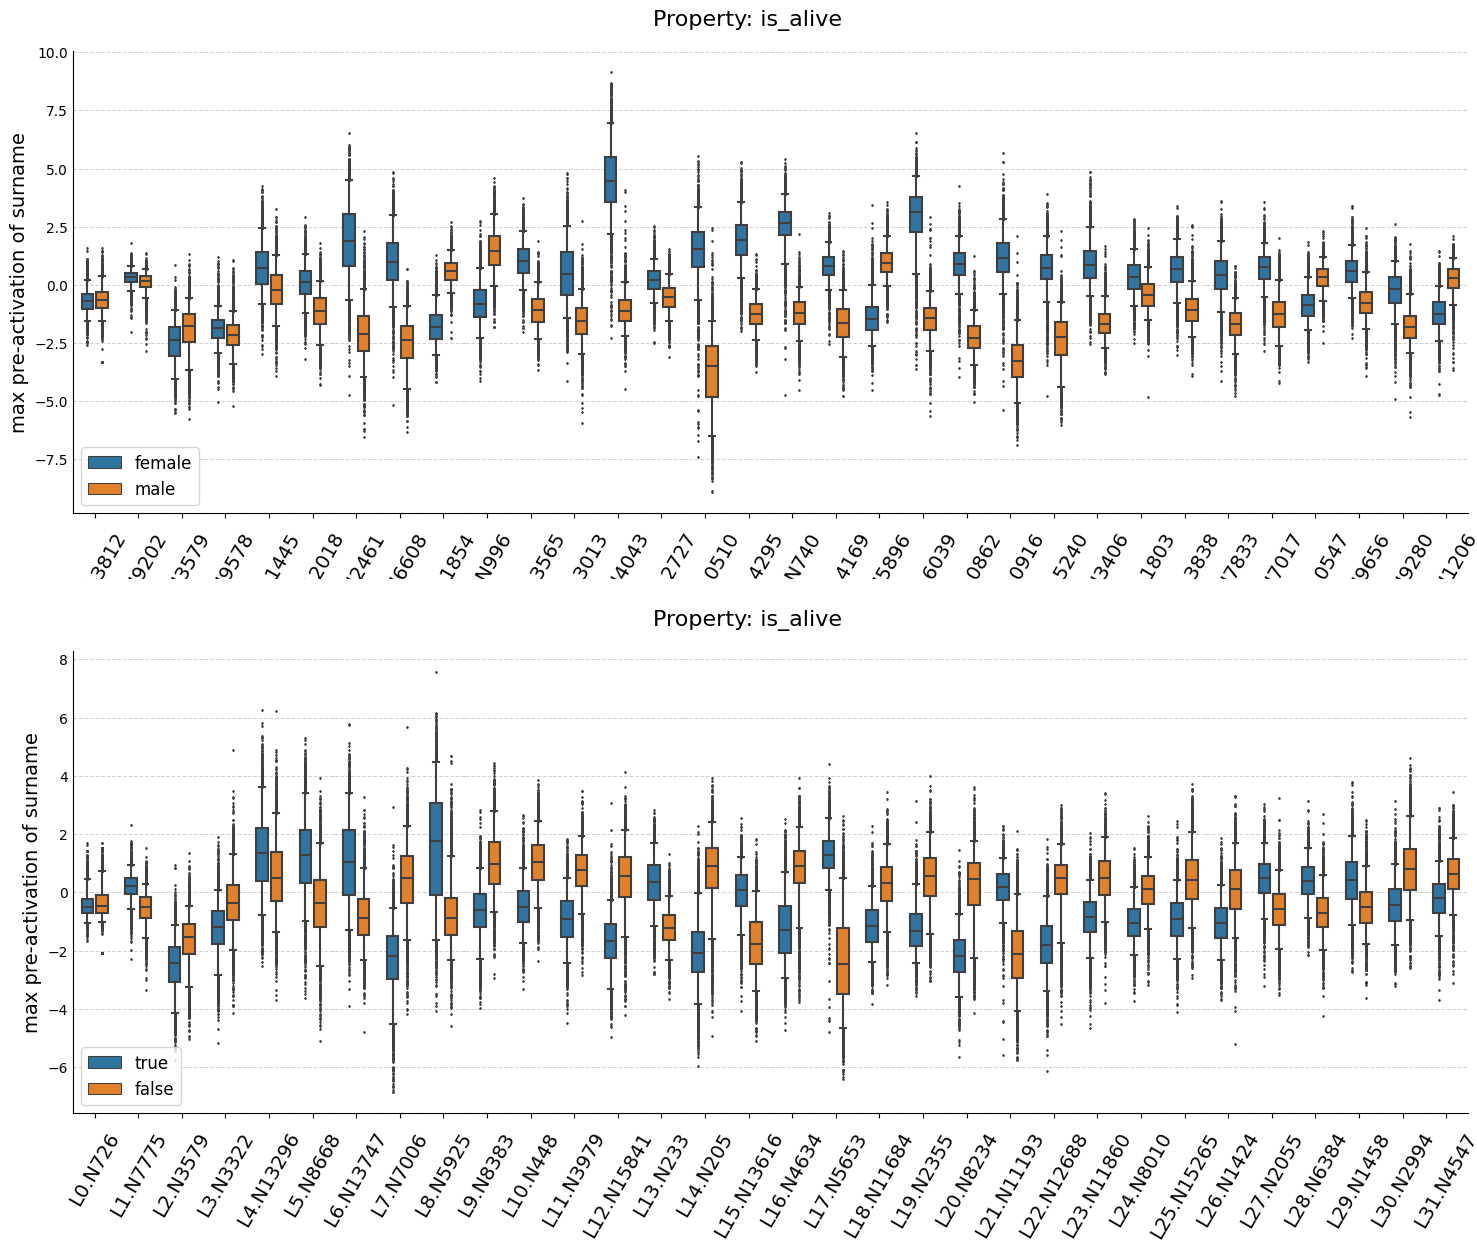

In [208]:
# sex or gender top neuron by f1 score for each layer
property = 'sex_or_gender'
value = 'female'

f1_lookup = {n: f1['test_f1_score'] for n, f1 in zip(results[property]['class_neurons'][value], results[property]['class_neuron_stats'][value])}
f1_lookup

plot_neurons1 = [
    ('sex_or_gender', (12, 4043)),
    ('sex_or_gender', (16, 740)),
    ('sex_or_gender', (19, 16039)),
    ('sex_or_gender', (15, 14295)),
    ('sex_or_gender', (21, 10916)),
    ('sex_or_gender', (9, 996)),
    ('sex_or_gender', (18, 5896)),
    ('sex_or_gender', (17, 14169)),
    ('sex_or_gender', (20, 10862)),
    ('sex_or_gender', (14, 10510)),
    ('sex_or_gender', (8, 11854)),
    ('sex_or_gender', (10, 13565)),
    ('sex_or_gender', (6, 2461)),
    ('sex_or_gender', (23, 3406)),
    ('sex_or_gender', (22, 15240)),
    ('sex_or_gender', (31, 1206)),
    ('sex_or_gender', (27, 7017)),
    ('sex_or_gender', (7, 6608)),
    ('sex_or_gender', (28, 10547)),
    ('sex_or_gender', (25, 13838)),
    ('sex_or_gender', (29, 9656)),
    ('sex_or_gender', (26, 7833)),
    ('sex_or_gender', (5, 12018)),
    ('sex_or_gender', (11, 13013)),
    ('sex_or_gender', (2, 3579)),
    ('sex_or_gender', (13, 12727)),
    ('sex_or_gender', (4, 11445)),
    ('sex_or_gender', (24, 11803)),
    ('sex_or_gender', (1, 9202)),
    ('sex_or_gender', (30, 9280)),
    ('sex_or_gender', (0, 13812)),
    ('sex_or_gender', (3, 9578)),
]
plot_neurons1.sort(key=lambda x: x[1][0])

plot_neurons2 = [
    ('is_alive', (17, 5653)),
    ('is_alive', (14, 205)),
    ('is_alive', (16, 4634)),
    ('is_alive', (22, 12688)),
    ('is_alive', (11, 3979)),
    ('is_alive', (7, 7006)),
    ('is_alive', (12, 15841)),
    ('is_alive', (10, 448)),
    ('is_alive', (9, 8383)),
    ('is_alive', (20, 8234)),
    ('is_alive', (19, 2355)),
    ('is_alive', (23, 11860)),
    ('is_alive', (18, 11684)),
    ('is_alive', (25, 15265)),
    ('is_alive', (30, 2994)),
    ('is_alive', (24, 8010)),
    ('is_alive', (26, 1424)),
    ('is_alive', (8, 5925)),
    ('is_alive', (2, 3579)),
    ('is_alive', (31, 4547)),
    ('is_alive', (1, 7775)),
    ('is_alive', (13, 233)),
    ('is_alive', (28, 6384)),
    ('is_alive', (3, 3322)),
    ('is_alive', (6, 13747)),
    ('is_alive', (5, 8668)),
    ('is_alive', (21, 11193)),
    ('is_alive', (27, 2055)),
    ('is_alive', (15, 13616)),
    ('is_alive', (29, 1458)),
    ('is_alive', (0, 726)),
    ('is_alive', (4, 13296)),
]
plot_neurons2.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(18, 12))
subfigs = fig.subfigures(2, 1, wspace=0, hspace=.1, squeeze=False).flatten()

for subfig_ix, plot_neurons in enumerate((plot_neurons1, plot_neurons2)):
    axes = subfigs[subfig_ix].subplots(1, len(plot_neurons), sharey=True)

    hue_order = []
    for ix, (property, neuron) in enumerate(plot_neurons):
        classes = results[property]['classes']

        ax = axes[ix]
        activation_df_subset = activation_df.loc[(activation_df['neuron'] == neuron) & (activation_df['property'] == property)]
        bp = sns.boxplot(activation_df_subset, x='class', y='activation', ax=ax, whis=whis, dodge=False,
                        fliersize=fliersize, hue='class')# , hue_order=hue_order)

        # only put a legend in the first subplot
        if ix == 0:
            ax.legend(loc='lower left', prop={'size': 12}, frameon=True)
            ax.set_zorder(100)
        else:
            ax.legend('', frameon=False)

        # formatting
        ax.set_xlabel(f'L{neuron[0]}.N{neuron[1]}', fontsize=14, rotation=60)
        # ax.set_xlabel(f'L{neuron[0]}', fontsize=14)
        ax.set_xticks([.5], '')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_axisbelow(True)  # move grid behind the plots
        ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
        ax.tick_params(axis='y', which='both', length=0)
        if ix == 0:
            ax.set_ylabel('max pre-activation of surname', fontsize=14)
        else:
            ax.set_ylabel('')
            ax.spines['left'].set_visible(False)

        ax.set_xlim([-1, len(classes)])

subfigs[0].suptitle(f'Property: {property}', fontsize=16, y=.95)
subfigs[1].suptitle(f'Property: is_alive', fontsize=16, y=.95)
fig.subplots_adjust(wspace=0, hspace=0)